# 1-dim Ising Model
In one dimension the Ising Model consist of $L$ spins sitting on a line, each one can be upwards on downwards and are characterized by the spin state $\vec{s} = (s_1, s_2, \dots, s_L)^T$ with each taking possible values $s_i = \pm 1$. Then in the first neighbour approximation where each spin only interacts with each closest neighbours the Hamiltonian of the chain is given by:
$$
\mathcal{H} = -J\sum_{j=1}^{L-1}\, s_js_{j+1}
$$
There are $2^L$ possible spin states.  
We want to learn a model which considers the energies of the interactions of one spin with all the others, not just the first neighbours. Then, if $w_{i,j}$ is the strength of the interaction between $s_i$ and $s_j$ then the Hamiltonian for this system is:
$$
\mathcal{H}_{\text{model}} = -\sum_{j,k \,= \, 1}^L \, w_{j, k}s_js_k
$$  
We generate a dataset as follows:
- randomly generate $n$ spin states $\vec{s}^{(i)}\in \mathbb{R}^L$, $i=1,\cdots, n$
- calculate their energies using the Ising Model Hamiltonian with first neighbours approximation $E(\vec{s}^{(i)})$
- reshape the state vector as $x = \vec{s}\cdot\vec{s}^T \in \mathbb{R}^{L^2}$
- we have generated a data set $x^{(i)}, E^{(i)}$  
- the model Hamiltonian is just Linear Regrassion since:
$$
\mathcal{H}_{\text{model}} = \sum_{j \,= \, 1}^{L^2} \, w_{j}x_{j} = \vec{w}\cdot \vec{x}
$$  

We can then train a Linear Regression model against the generated dataset to learn the interactions $\vec{w}$ between all spins 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def generate_data_set(n, L):
    '''n is the number of samples and L is the dimension of the spin chain.
    Notice that each training example will have L**2 features 
    '''

    states = np.random.choice([-1, 1], size = (n, L))
    
    # calculate the first-nbr approx. energies of the states
    
    # energy matrix of first neighbours
    J = np.zeros((L, L))
    for j in range(L-1):
        J[j, j+1] = -1
    
    energies = np.einsum('...i,...ij,...j', states, J, states)
    
    # form the x-states, each with dim L, L
    x = np.einsum('...i,...j->...ij', states, states)
    # reshape them in the shape n, L^2
    x = x.reshape(n, -1)

    return x, energies

In [3]:
def linear_regression(x_train, x_test, y_train, y_test):
    model = linear_model.LinearRegression()
    model.fit(x_train, y_train)
    y_train_hat = model.predict(x_train)
    y_test_hat = model.predict(x_test)
    
    R2_train, R2_test = model.score(x_train, y_train), model.score(x_test, y_test) 
    mse_train = metrics.mean_squared_error(y_train, y_train_hat)
    mse_test = metrics.mean_squared_error(y_test, y_test_hat)
    
    return R2_train, R2_test, mse_train, mse_test

def linear_Ringe(x_train, x_test, y_train, y_test, alpha = 1):
    '''Use the Ringe model which is LR with L2 regularization,
    alpha is the constant multiplying the regularization term
    '''

    model = linear_model.Ridge(alpha=alpha)
    model.fit(x_train, y_train)
    y_train_hat = model.predict(x_train)
    y_test_hat = model.predict(x_test)

    R2_train, R2_test = model.score(x_train, y_train), model.score(x_test, y_test) 
    mse_train = metrics.mean_squared_error(y_train, y_train_hat)
    mse_test = metrics.mean_squared_error(y_test, y_test_hat)
    
    return R2_train, R2_test, mse_train, mse_test

def linear_Lasso(x_train, x_test, y_train, y_test, alpha = 1):
    '''Use Lasso model which is LR with L1 regularization,
    alpha is the constant multiplying the regularization term
    '''
    
    model = linear_model.Lasso(alpha=alpha)
    model.fit(x_train, y_train)
    y_train_hat = model.predict(x_train)
    y_test_hat = model.predict(x_test)

    R2_train, R2_test = model.score(x_train, y_train), model.score(x_test, y_test) 
    mse_train = metrics.mean_squared_error(y_train, y_train_hat)
    mse_test = metrics.mean_squared_error(y_test, y_test_hat)
    
    return R2_train, R2_test, mse_train, mse_test

In [4]:
# vary the number of examples

L = 40
sizes  = [100, 200, 500, 1000]
r_train_linear, r_test_linear, mse_train_linear, mse_test_linear = [], [], [], []
r_train_ringe, r_test_ringe, mse_train_ringe, mse_test_ringe = [], [], [], []
r_train_lasso, r_test_lasso, mse_train_lasso, mse_test_lasso = [], [], [], []

for n in sizes:
    x, y = generate_data_set(n, L)
    # assert x.shape, y.shape == ((1000, 10), (1000, ) )

    # split into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    # linear regression
    r_train, r_test, mse_train, mse_test = linear_regression(x_train, x_test, y_train, y_test)
    r_train_linear.append(r_train)
    r_test_linear.append(r_test)
    mse_train_linear.append(mse_train)
    mse_test_linear.append(mse_test)
    
    # linear regression, L2 normalization
    r_train, r_test, mse_train, mse_test = linear_Ringe(x_train, x_test, y_train, y_test)
    r_train_ringe.append(r_train)
    r_test_ringe.append(r_test)
    mse_train_ringe.append(mse_train)
    mse_test_ringe.append(mse_test)

    # linear regression l1 normalization
    r_train, r_test, mse_train, mse_test = linear_Lasso(x_train, x_test, y_train, y_test)
    r_train_lasso.append(r_train)
    r_test_lasso.append(r_test)
    mse_train_lasso.append(mse_train)
    mse_test_lasso.append(mse_test)

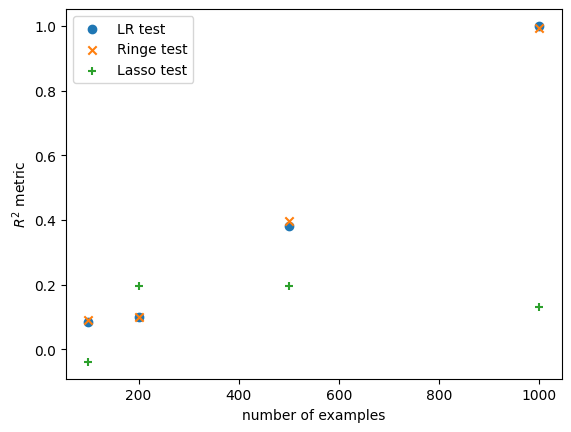

In [5]:
# plt.scatter(sizes, r_train_linear, label = 'LR train')
plt.scatter(sizes, r_test_linear, label = 'LR test')
# plt.scatter(sizes, r_train_ringe, label = 'Ringe train', marker='x')
plt.scatter(sizes, r_test_ringe, label = 'Ringe test', marker= 'x')
# plt.scatter(sizes, r_train_lasso, label = 'Lasso train', marker='+')
plt.scatter(sizes, r_test_lasso, label = 'Lasso test', marker= '+')
plt.ylabel('$R^2$ metric')
plt.xlabel('number of examples')
plt.legend()
plt.show()

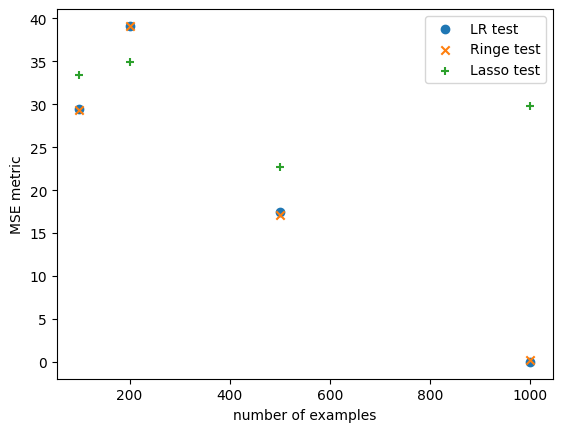

In [6]:
# plt.scatter(sizes, mse_train_linear, label = 'LR train')
plt.scatter(sizes, mse_test_linear, label = 'LR test')
# plt.scatter(sizes, mse_train_ringe, label = 'Ringe train', marker='x')
plt.scatter(sizes, mse_test_ringe, label = 'Ringe test', marker= 'x')
# plt.scatter(sizes, mse_train_lasso, label = 'Lasso train', marker='+')
plt.scatter(sizes, mse_test_lasso, label = 'Lasso test', marker= '+')
plt.xlabel('number of examples')
plt.ylabel('MSE metric')
plt.legend()
plt.show()

Mean Square Error on the test set decreases with increases in the number of examples.

In [7]:
# vary the normalization strength

L = 40
n = 500
reg_strengths  = np.logspace(-4, 5, 10)

r_train_linear, r_test_linear, mse_train_linear, mse_test_linear = [], [], [], []
r_train_ringe, r_test_ringe, mse_train_ringe, mse_test_ringe = [], [], [], []
r_train_lasso, r_test_lasso, mse_train_lasso, mse_test_lasso = [], [], [], []

x, y = generate_data_set(n, L)

# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

for a in reg_strengths:
    # linear regression
    r_train, r_test, mse_train, mse_test = linear_regression(x_train, x_test, y_train, y_test)
    r_train_linear.append(r_train)
    r_test_linear.append(r_test)
    mse_train_linear.append(mse_train)
    mse_test_linear.append(mse_test)
    
    # linear regression, L2 normalization
    r_train, r_test, mse_train, mse_test = linear_Ringe(x_train, x_test, y_train, y_test, alpha=a)
    r_train_ringe.append(r_train)
    r_test_ringe.append(r_test)
    mse_train_ringe.append(mse_train)
    mse_test_ringe.append(mse_test)

    # linear regression l1 normalization
    r_train, r_test, mse_train, mse_test = linear_Lasso(x_train, x_test, y_train, y_test, alpha=a)
    r_train_lasso.append(r_train)
    r_test_lasso.append(r_test)
    mse_train_lasso.append(mse_train)
    mse_test_lasso.append(mse_test)

c:\Users\USER\Desktop\Venv ML\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.689e+00, tolerance: 1.574e+00
  model = cd_fast.enet_coordinate_descent(


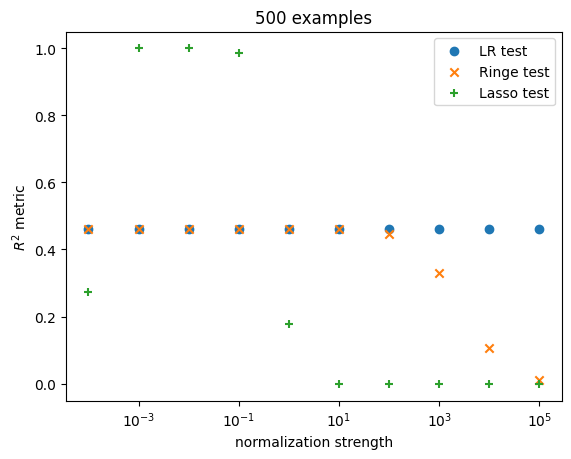

In [8]:
# plt.scatter(reg_strengths, r_train_linear, label = 'LR train')
plt.scatter(reg_strengths, r_test_linear, label = 'LR test')
# plt.scatter(reg_strengths, r_train_ringe, label = 'Ringe train', marker='x')
plt.scatter(reg_strengths, r_test_ringe, label = 'Ringe test', marker= 'x')
# plt.scatter(reg_strengths, r_train_lasso, label = 'Lasso train', marker='+')
plt.scatter(reg_strengths, r_test_lasso, label = 'Lasso test', marker= '+')
plt.ylabel('$R^2$ metric')
plt.xlabel('normalization strength')
plt.xscale('log')
plt.title('500 examples')
plt.legend()
plt.show()

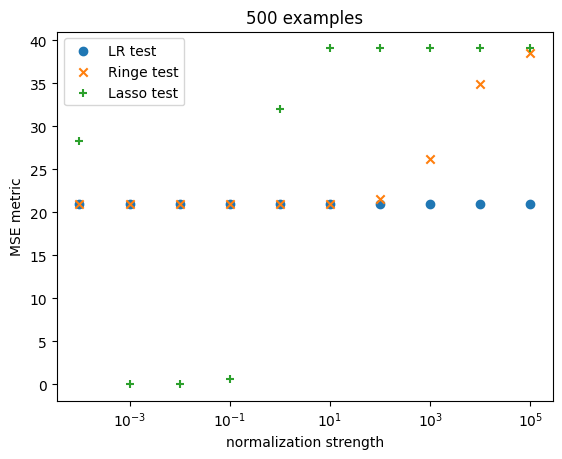

In [9]:
# plt.scatter(reg_strengths, mse_train_linear, label = 'LR train')
plt.scatter(reg_strengths, mse_test_linear, label = 'LR test')
# plt.scatter(reg_strengths, mse_train_ringe, label = 'Ringe train', marker='x')
plt.scatter(reg_strengths, mse_test_ringe, label = 'Ringe test', marker= 'x')
# plt.scatter(reg_strengths, mse_train_lasso, label = 'Lasso train', marker='+')
plt.scatter(reg_strengths, mse_test_lasso, label = 'Lasso test', marker= '+')
plt.ylabel('MSE metric')
plt.xlabel('normalization strength')
plt.xscale('log')
plt.title('500 examples')
plt.legend()
plt.show()

For the Lasso (L1 regularization) there is an optimal choice for the hyperparameter of the regularization strength of about $10^{-3}-10^{-1}$.